In [1]:
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Not connected to a GPU')
else:
  print(gpu_info)

Thu Feb 26 04:40:02 2026       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 580.82.07              Driver Version: 580.82.07      CUDA Version: 13.0     |
+-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  NVIDIA L4                      Off |   00000000:00:03.0 Off |                    0 |
| N/A   37C    P8             12W /   72W |       0MiB /  23034MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

#**Setup & Imports**

In [ ]:


import os
import PIL
import random
import numpy as np

import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from collections import Counter
import seaborn as sns
from PIL import Image
Image.MAX_IMAGE_PIXELS = None
from sklearn.utils.class_weight import compute_class_weight
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import Callback
import time
from tensorflow.keras.callbacks import ModelCheckpoint
import pickle
import datetime
from keras.callbacks import ReduceLROnPlateau, EarlyStopping
pass_name = "LCSNet_3"
img_size = 224

import tensorflow as tf
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))




Found GPU at: /device:GPU:0


In [ ]:
import matplotlib.pyplot as plt

def plot_accuracy_loss_chart(history):
    """
    Plot training vs. validation accuracy and loss across epochs.

    Args:
        history (tf.keras.callbacks.History): Training history object returned by model.fit().
    """
    epochs = range(len(history.history['accuracy']))
    fig, ax = plt.subplots(1, 2, figsize=(20, 10))

    # Accuracy curves
    train_acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    ax[0].plot(epochs, train_acc, 'g-', label='Training Accuracy')
    ax[0].plot(epochs, val_acc, 'r-', label='Validation Accuracy')
    ax[0].set_title(f'Training & Validation Accuracy - {pass_name}')
    ax[0].set_xlabel("Epochs")
    ax[0].set_ylabel("Accuracy")
    ax[0].legend()

    # Loss curves
    train_loss = history.history['loss']
    val_loss = history.history['val_loss']
    ax[1].plot(epochs, train_loss, 'g-', label='Training Loss')
    ax[1].plot(epochs, val_loss, 'r-', label='Validation Loss')
    ax[1].set_title(f'Training & Validation Loss - {pass_name}')
    ax[1].set_xlabel("Epochs")
    ax[1].set_ylabel("Loss")
    ax[1].legend()

    plt.show()


def plot_accuracy_loss_chart_1(history):
    """
    Plot training accuracy and training loss only across epochs.

    Args:
        history (tf.keras.callbacks.History): Training history object returned by model.fit().
    """
    epochs = range(len(history.history['accuracy']))
    fig, ax = plt.subplots(1, 2, figsize=(20, 10))

    # Training accuracy curve
    train_acc = history.history['accuracy']
    ax[0].plot(epochs, train_acc, 'g-', label='Training Accuracy')
    ax[0].set_title(f'Training Accuracy - {pass_name}')
    ax[0].set_xlabel("Epochs")
    ax[0].set_ylabel("Accuracy")
    ax[0].legend()

    # Training loss curve
    train_loss = history.history['loss']
    ax[1].plot(epochs, train_loss, 'g-', label='Training Loss')
    ax[1].set_title(f'Training Loss - {pass_name}')
    ax[1].set_xlabel("Epochs")
    ax[1].set_ylabel("Loss")
    ax[1].legend()

    plt.show()

#**Exploratory Data Analysis (EDA)**

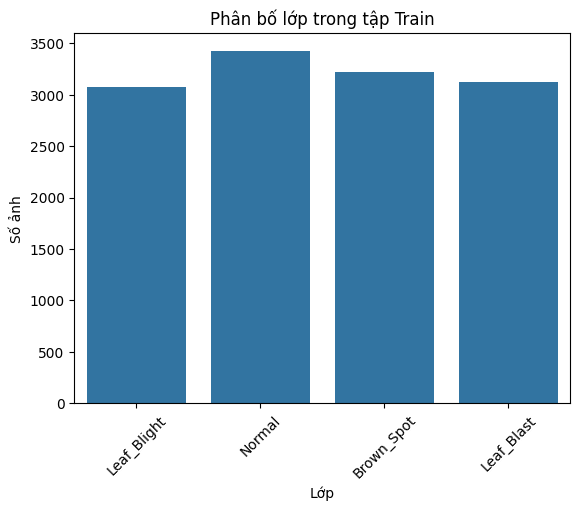

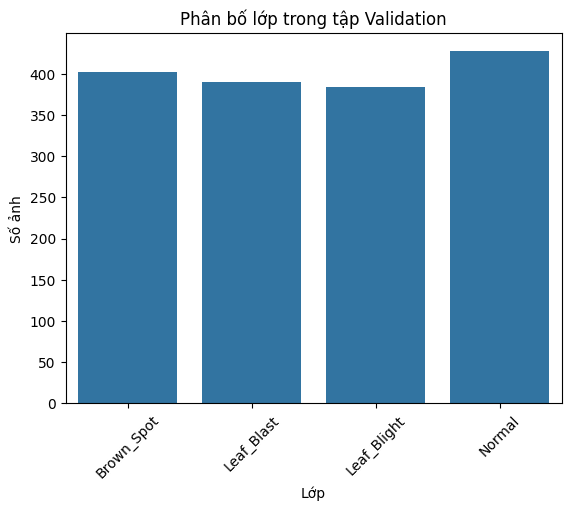

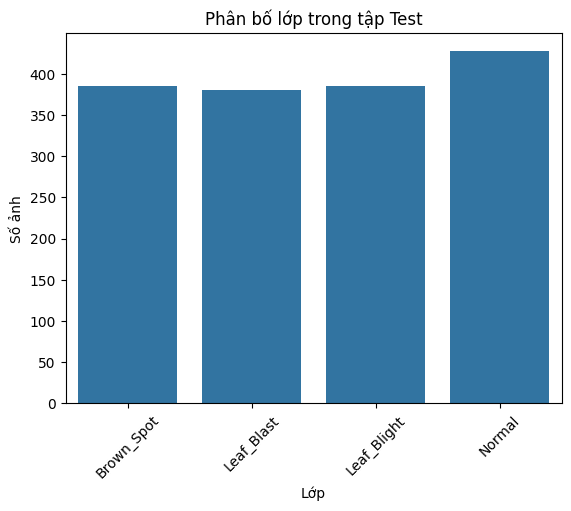

In [ ]:
import os
import seaborn as sns
import matplotlib.pyplot as plt

# -----------------------------
# Define dataset directories
# -----------------------------
train_dir = '/content/drive/MyDrive/global/dataset/train'
valid_dir = '/content/drive/MyDrive/global/dataset/val'
test_dir  = '/content/drive/MyDrive/global/dataset/test'


def plot_class_distribution(directory: str, title: str):
    """
    Plot the distribution of images per class in a given dataset directory.

    Args:
        directory (str): Path to dataset directory containing subfolders for each class.
        title (str): Title for the plot.

    Returns:
        dict: Dictionary mapping class names to image counts.
    """
    class_counts = {}
    for cls in os.listdir(directory):
        class_path = os.path.join(directory, cls)
        if os.path.isdir(class_path):
            class_counts[cls] = len(os.listdir(class_path))

    # Plot class distribution
    sns.barplot(
        x=list(class_counts.keys()),
        y=list(class_counts.values())
    )
    plt.title(title)
    plt.ylabel("Number of Images")
    plt.xlabel("Class")
    plt.xticks(rotation=45)
    plt.show()

    return class_counts


# -----------------------------
# Analyze dataset distributions
# -----------------------------
train_counts = plot_class_distribution(train_dir, "Class Distribution in Training Set")
valid_counts = plot_class_distribution(valid_dir, "Class Distribution in Validation Set")
test_counts  = plot_class_distribution(test_dir,  "Class Distribution in Test Set")


#**Data Augmentation**

In [ ]:
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=40,              # increase rotation angle for more diversity
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.3,                 # higher zoom to simulate close cropping
    horizontal_flip=True,
    vertical_flip=True,             # add vertical flip — rice leaf disease can still be recognized
    brightness_range=[0.7, 1.3],    # simulate different lighting conditions
    fill_mode='reflect'             # avoid creating artificial boundary regions
)

valid_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(img_size, img_size),
    batch_size=32,
    class_mode='categorical'
)

valid_generator = valid_datagen.flow_from_directory(
    valid_dir,
    target_size=(img_size, img_size),
    batch_size=32,
    class_mode='categorical'
)

test_generator = valid_datagen.flow_from_directory(
    test_dir,
    target_size=(img_size, img_size),
    batch_size=32,
    class_mode='categorical',
    shuffle=False
)


Found 12843 images belonging to 4 classes.
Found 1604 images belonging to 4 classes.
Found 1580 images belonging to 4 classes.


In [ ]:
# Calculate class_weight to use in model.fit
# Assign higher weights to classes with fewer samples, helping the model avoid bias toward majority classes.
classes = sorted(os.listdir(train_dir))
class_indices = {cls: i for i, cls in enumerate(classes)}
labels = []

for cls in classes:
    cls_dir = os.path.join(train_dir, cls)
    count = len(os.listdir(cls_dir))
    labels.extend([class_indices[cls]] * count)

class_weights = compute_class_weight(class_weight='balanced', classes=np.unique(labels), y=labels)
class_weights_dict = dict(enumerate(class_weights))
print("Class Weights:", class_weights_dict)


Class Weights: {0: np.float64(0.9971273291925465), 1: np.float64(1.027768886043534), 2: np.float64(1.0444860117111257), 3: np.float64(0.9374452554744526)}


In [ ]:
# -----------------------------
# Compute Class Weights
# -----------------------------
# Assign higher weights to underrepresented classes to reduce bias during training
classes = sorted(os.listdir(train_dir))
class_indices = {cls: i for i, cls in enumerate(classes)}
labels = []

# Collect labels based on image counts per class
for cls in classes:
    cls_dir = os.path.join(train_dir, cls)
    count = len(os.listdir(cls_dir))
    labels.extend([class_indices[cls]] * count)

# Compute balanced class weights
class_weights = compute_class_weight(
    class_weight='balanced',
    classes=np.unique(labels),
    y=labels
)
class_weights_dict = dict(enumerate(class_weights))
print("Class Weights:", class_weights_dict)


# -----------------------------
# Custom Callback for Epoch Timing
# -----------------------------
class TimeHistory(Callback):
    """
    Keras Callback to record training time per epoch.
    Useful for performance monitoring and reporting.
    """
    def on_train_begin(self, logs=None):
        self.times = []

    def on_epoch_begin(self, epoch, logs=None):
        self.epoch_time_start = time.time()

    def on_epoch_end(self, epoch, logs=None):
        self.times.append(time.time() - self.epoch_time_start)


# Instantiate timing callback
time_callback = TimeHistory()

# -----------------------------
# TensorBoard Extension
# -----------------------------
# Load TensorBoard notebook extension for visualization
%load_ext tensorboard

Class Weights: {0: np.float64(0.9971273291925465), 1: np.float64(1.027768886043534), 2: np.float64(1.0444860117111257), 3: np.float64(0.9374452554744526)}


#**Detailed Architecture**

In [ ]:
#--------------------------
# Custom Keras Layers for Global Pooling
# -----------------------------
@tf.keras.utils.register_keras_serializable()
class GlobalAveragePooling2DLayer(layers.Layer):
    """Custom Global Average Pooling that keeps dimensions for spatial attention."""
    def call(self, inputs):
        return tf.reduce_mean(inputs, axis=-1, keepdims=True)


@tf.keras.utils.register_keras_serializable()
class GlobalMaxPooling2DLayer(layers.Layer):
    """Custom Global Max Pooling that keeps dimensions for spatial attention."""
    def call(self, inputs):
        return tf.reduce_max(inputs, axis=-1, keepdims=True)


# -----------------------------
# Improved CBAM Block
# -----------------------------
@tf.keras.utils.register_keras_serializable()
def improve_cbam_block(input_feature, gamma=2, b=1):
    """
    Improved CBAM block with lightweight channel attention and optimized spatial attention.

    Args:
        input_feature (tf.Tensor): Input feature map.
        gamma (int): Hyperparameter for kernel size calculation.
        b (int): Bias term for kernel size calculation.

    Returns:
        tf.Tensor: Refined feature map after attention.
    """
    channel = input_feature.shape[-1]

    # Dynamic kernel size adaptation for channel attention
    t = int(abs((math.log2(channel) + b) / gamma))
    k = max(3, t if t % 2 else t + 1)  # Ensure odd kernel size, minimum 3

    # --- Lightweight Channel Attention ---
    avg_pool = layers.GlobalAveragePooling2D()(input_feature)
    avg_pool = layers.Reshape((1, 1, channel))(avg_pool)

    channel_attention = layers.DepthwiseConv2D(
        kernel_size=(k, 1),
        padding='same',
        activation='sigmoid',
        use_bias=False,
        depthwise_initializer='he_normal'
    )(avg_pool)

    channel_refined = layers.Multiply()([input_feature, channel_attention])

    # --- Spatial Attention ---
    avg_spatial = GlobalAveragePooling2DLayer()(channel_refined)
    max_spatial = GlobalMaxPooling2DLayer()(channel_refined)
    concat_spatial = layers.Concatenate(axis=-1)([avg_spatial, max_spatial])

    spatial_attention = layers.Conv2D(
        filters=1,
        kernel_size=7,
        padding='same',
        activation='sigmoid',
        use_bias=False,
        kernel_initializer='he_normal'
    )(concat_spatial)

    refined_feature = layers.Multiply()([channel_refined, spatial_attention])
    return refined_feature


# -----------------------------
# Residual Block with Improve-CBAM
# -----------------------------
@tf.keras.utils.register_keras_serializable()
def residual_improve_cbam_block(x, filters, strides=1, dropout_rate=0.1, use_attention=True):
    """
    Residual block integrating improved CBAM.

    Args:
        x (tf.Tensor): Input tensor.
        filters (int): Number of filters.
        strides (int): Stride size.
        dropout_rate (float): Dropout rate.
        use_attention (bool): Whether to apply CBAM attention.

    Returns:
        tf.Tensor: Output tensor after residual connection and attention.
    """
    shortcut = x

    # Main path
    x = layers.SeparableConv2D(
        filters, kernel_size=3, strides=strides, padding='same',
        depthwise_initializer='he_normal',
        pointwise_initializer='he_normal'
    )(x)
    x = layers.BatchNormalization()(x)
    x = layers.ReLU(max_value=6)(x)  # ReLU6 for quantization-friendly activations

    # Apply attention if enabled
    if use_attention:
        x = improve_cbam_block(x)

    # Shortcut path adjustment
    if shortcut.shape[-1] != filters or strides != 1:
        shortcut = layers.Conv2D(filters, 1, strides=strides, padding='same',
                                 kernel_initializer='he_normal')(shortcut)
        shortcut = layers.BatchNormalization()(shortcut)

    # Residual connection
    x = layers.Add()([x, shortcut])
    x = layers.ReLU(max_value=6)(x)
    x = layers.Dropout(dropout_rate)(x)
    return x


# -----------------------------
# Full Network Architecture (LCSNet_3)
# -----------------------------
@tf.keras.utils.register_keras_serializable()
def LCSNet_3(input_shape=(224, 224, 3), num_classes=4,
             dropout_rate=0.2, l2_reg=1e-5,
             attention_gamma=2, attention_b=1):
    """
    Full network architecture with improved CBAM hybrid design.
    Optimized for federated learning and edge devices.

    Args:
        input_shape (tuple): Input image shape.
        num_classes (int): Number of output classes.
        dropout_rate (float): Base dropout rate.
        l2_reg (float): L2 regularization factor.
        attention_gamma (int): Gamma parameter for CBAM kernel size.
        attention_b (int): Bias parameter for CBAM kernel size.

    Returns:
        tf.keras.Model: Compiled LCSNet_3 model.
    """
    inputs = tf.keras.Input(shape=input_shape)

    # --- Stem Layers ---
    x = layers.Conv2D(16, (3, 3), strides=2, padding='same',
                      activation="swish",
                      kernel_initializer='he_normal',
                      kernel_regularizer=tf.keras.regularizers.l2(l2_reg))(inputs)
    x = layers.BatchNormalization()(x)

    x = layers.Conv2D(32, (3, 3), strides=1, padding='same',
                      activation="swish",
                      kernel_initializer='he_normal',
                      kernel_regularizer=tf.keras.regularizers.l2(l2_reg))(x)
    x = layers.BatchNormalization()(x)

    # --- Backbone Configuration ---
    backbone_config = [
        (32, 1, True, 2),    # Stage 1: 2 blocks
        (64, 2, True, 2),    # Stage 2: 2 blocks
        (128, 2, True, 2),   # Stage 3: 2 blocks
        (256, 2, True, 1),   # Stage 4: 1 block
        (512, 2, True, 1),   # Stage 5: 1 block
        (1024, 2, False, 1)  # Stage 6: 1 block (no attention for efficiency)
    ]

    for i, (filters, strides, use_attn, num_blocks) in enumerate(backbone_config):
        current_dropout = dropout_rate * (0.75 ** i)  # Gentle decay
        for block_idx in range(num_blocks):
            current_strides = strides if block_idx == 0 else 1
            x = residual_improve_cbam_block(
                x, filters,
                strides=current_strides,
                dropout_rate=max(0.05, current_dropout),
                use_attention=use_attn
            )

    # --- Feature Aggregation ---
    x = layers.GlobalAveragePooling2D()(x)
    x = layers.Dropout(0.3)(x)

    # --- Classifier Head ---
    x = layers.Dense(96, activation="swish",
                     kernel_initializer='he_normal',
                     kernel_regularizer=tf.keras.regularizers.l2(l2_reg))(x)
    x = layers.BatchNormalization()(x)
    x = layers.Dropout(0.2)(x)

    x = layers.Dense(64, activation="swish",
                     kernel_initializer='he_normal')(x)
    x = layers.Dropout(0.1)(x)

    outputs = layers.Dense(num_classes, activation='softmax',
                           kernel_initializer='he_normal')(x)

    model = Model(inputs, outputs, name='LCSNet_3')
    return model


# -----------------------------
# Model Initialization & Compilation
# -----------------------------
input_shape = (224, 224, 3)
num_classes = 4

# Callbacks
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, min_lr=1e-5)
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

# Create and compile the model
model = LCSNet_3(
    input_shape=input_shape,
    num_classes=num_classes,
    dropout_rate=0.15,
    l2_reg=1e-5
)
model.compile(
    optimizer=Adam(learning_rate=0.001),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

# Print model summary
model.summary()

Model: "LCSNet_3"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d (Conv2D)     │ (None, 112, 112,  │        448 │ input_layer[0][0] │
│                     │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalization │ (None, 112, 112,  │         64 │ conv2d[0][0]      │
│ (BatchNormalizatio… │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_1 (Conv2D)   │ (None, 112, 112,  │      4,640 │ batch_normalizat… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 112, 112,  │        128 │ conv2d_1[0][0]    │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ separable_conv2d    │ (None, 112, 112,  │      1,344 │ batch_normalizat… │
│ (SeparableConv2D)   │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 112, 112,  │        128 │ separable_conv2d… │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ re_lu (ReLU)        │ (None, 112, 112,  │          0 │ batch_normalizat… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ global_average_poo… │ (None, 32)        │          0 │ re_lu[0][0]       │
│ (GlobalAveragePool… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ reshape (Reshape)   │ (None, 1, 1, 32)  │          0 │ global_average_p… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ depthwise_conv2d    │ (None, 1, 1, 32)  │         96 │ reshape[0][0]     │
│ (DepthwiseConv2D)   │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ multiply (Multiply) │ (None, 112, 112,  │          0 │ re_lu[0][0],      │
│                     │ 32)               │            │ depthwise_conv2d… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ global_average_poo… │ (None, 112, 112,  │          0 │ multiply[0][0]    │
│ (GlobalAveragePool… │ 1)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ global_max_pooling… │ (None, 112, 112,  │          0 │ multiply[0][0]    │
│ (GlobalMaxPooling2… │ 1)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate         │ (None, 112, 112,  │          0 │ global_average_p… │
│ (Concatenate)       │ 2)                │            │ global_max_pooli… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_2 (Conv2D)   │ (None, 112, 112,  │         98 │ concatenate[0][0] │
│                     │ 1)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ multiply_1          │ (None, 112, 112,  │          0 │ multiply[0][0],   │
│ (Multiply)          │ 32)               │            │ conv2d_2[0][0]  

 Total params: 1,568,628 (5.98 MB)

 Trainable params: 1,559,892 (5.95 MB)

 Non-trainable params: 8,736 (34.12 KB)

In [4]:
from tensorflow.keras.utils import plot_model

plot_model(model, to_file='model_architecture.png', show_shapes=True, show_layer_names=True)

Output hidden; open in https://colab.research.google.com to view.

#**Trainning model**

In [ ]:
class TimeHistory(Callback):
    def on_train_begin(self, logs={}):
        self.times = []

    def on_epoch_begin(self, epoch, logs={}):
        self.epoch_time_start = time.time()

    def on_epoch_end(self, epoch, logs={}):
        self.times.append(time.time() - self.epoch_time_start)

time_callback = TimeHistory()
# Load the TensorBoard notebook extension
%load_ext tensorboard

/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/130
402/402 ━━━━━━━━━━━━━━━━━━━━ 0s 26s/step - accuracy: 0.4199 - loss: 1.3610 
Epoch 1: val_accuracy improved from -inf to 0.50998, saving model to /content/drive/MyDrive/new_base_model/models/9th11_Proposal_3_best_model.keras
402/402 ━━━━━━━━━━━━━━━━━━━━ 11922s 30s/step - accuracy: 0.4200 - loss: 1.3606 - val_accuracy: 0.5100 - val_loss: 1.0956 - learning_rate: 0.0010
Epoch 2/130
402/402 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.5971 - loss: 0.9818
Epoch 2: val_accuracy improved from 0.50998 to 0.66584, saving model to /content/drive/MyDrive/new_base_model/models/9th11_Proposal_3_best_model.keras
402/402 ━━━━━━━━━━━━━━━━━━━━ 569s 1s/step - accuracy: 0.5971 - loss: 0.9817 - val_accuracy: 0.6658 - val_loss: 0.8640 - learning_rate: 0.0010
Epoch 3/130
402/402 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.6364 - loss: 0.8854
Epoch 3: val_accuracy improved from 0.66584 to 0.69763, saving model to /content/drive/MyDrive/new_base_model/models/9th11_Proposal_3_best_model.keras
402

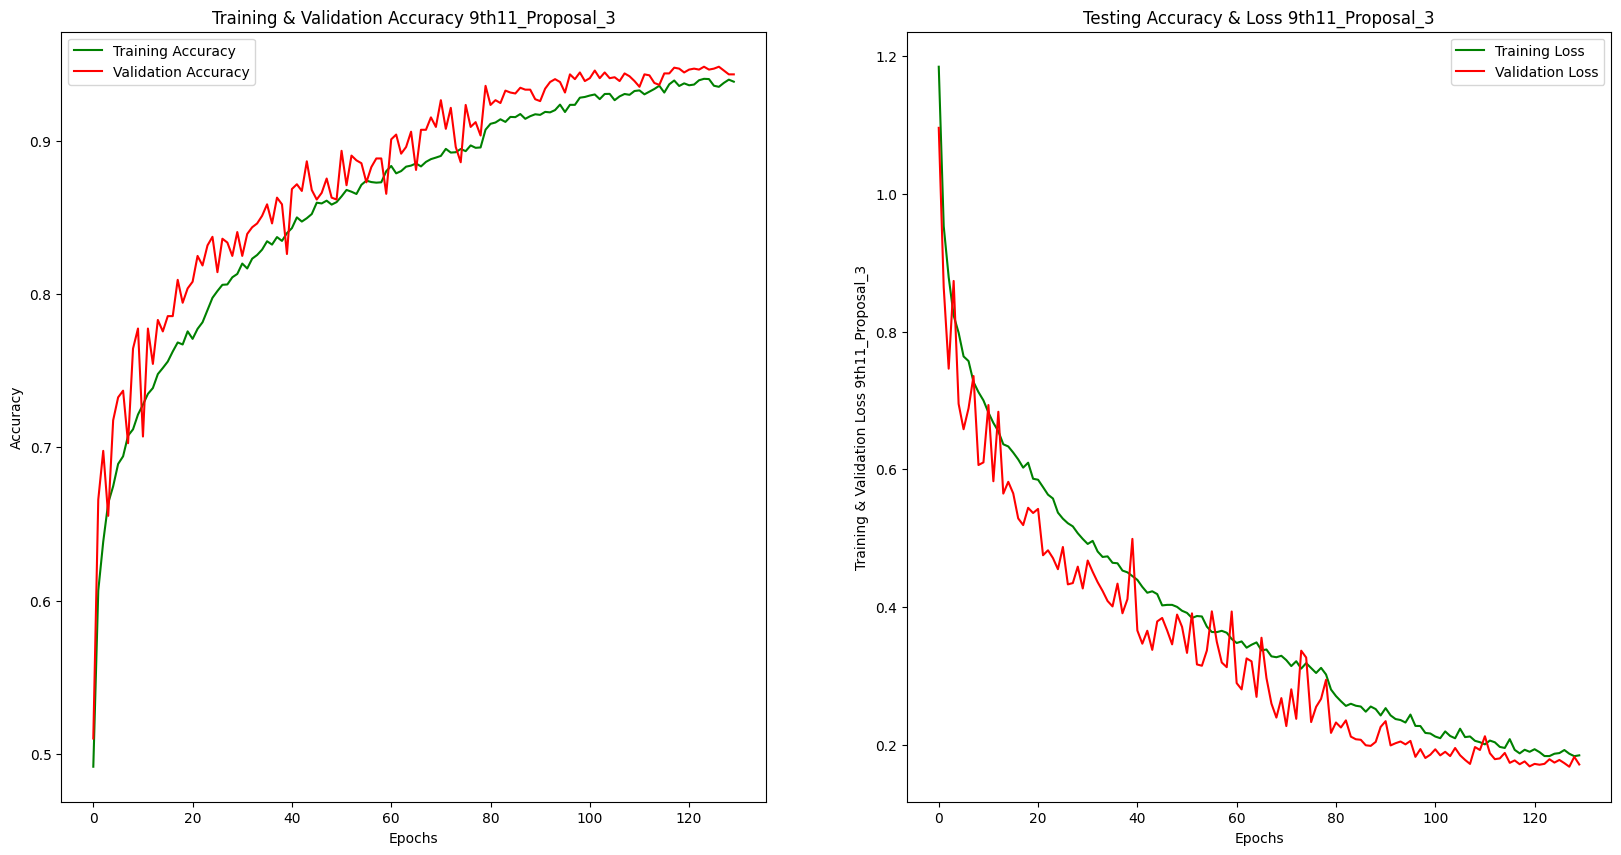

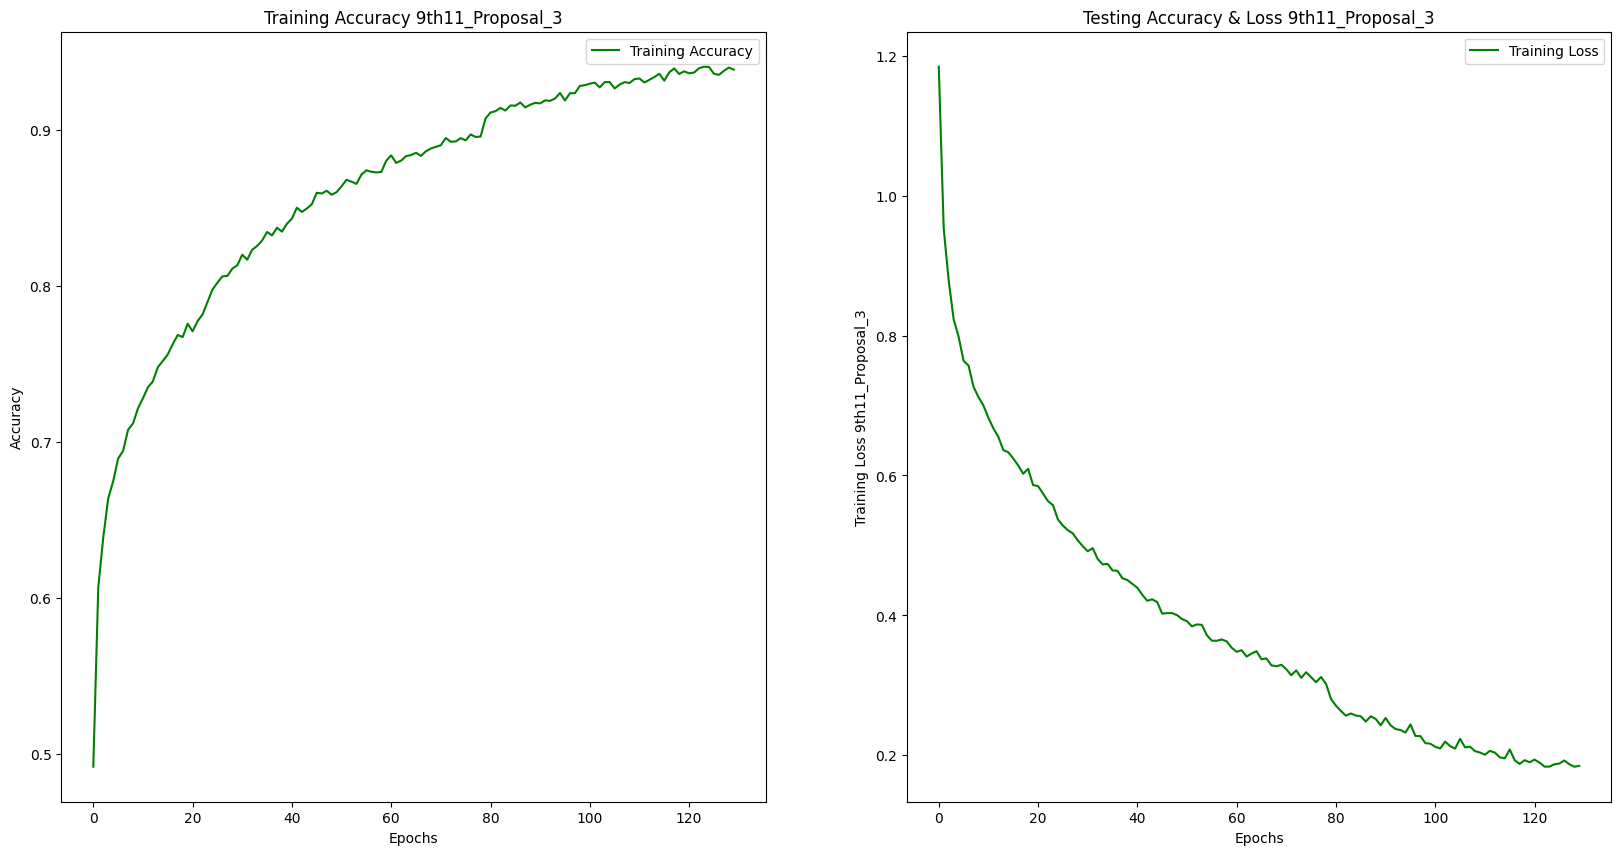

In [ ]:
# -----------------------------
# Callback Setup
# -----------------------------
# Learning rate scheduler: reduce LR when validation loss plateaus
lr_scheduler = tf.keras.callbacks.ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.5,          # Gradually reduce learning rate
    patience=8,          # Wait longer before reducing
    min_lr=1e-7,         # Minimum learning rate floor
    verbose=1,
    mode='min'
)

# Early stopping: stop training when validation loss stops improving
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=25,         # Higher patience for longer training
    restore_best_weights=True,
    verbose=1
)

# Model checkpoint: save the best model based on validation accuracy
checkpoint_filepath = os.path.join(
    '/content/drive/MyDrive/new_base_model/models',
    f"{pass_name}_best_model.keras"
)
model_checkpoint_callback = ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_best_only=True,
    monitor='val_accuracy',
    mode='max',
    verbose=1
)

# TensorBoard callback: log training metrics for visualization
log_dir = "logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = tf.keras.callbacks.TensorBoard(
    log_dir=log_dir,
    histogram_freq=1
)

# -----------------------------
# Model Training
# -----------------------------
start_time = time.time()

history = model.fit(
    train_generator,
    batch_size=32,
    epochs=130,  # Training epochs
    validation_data=valid_generator,
    class_weight=class_weights_dict,
    callbacks=[
        lr_scheduler,
        early_stopping,
        model_checkpoint_callback,
        time_callback,
        monitor
    ]
)

end_time = time.time()
print(f"⏱️ Total training time: {(end_time - start_time)/60:.2f} minutes")
print(f"⏱️ Per-epoch times: {time_callback.times}")
print(f"⏱️ Average per epoch: {sum(time_callback.times)/len(time_callback.times):.2f} seconds")

# -----------------------------
# Save Training History
# -----------------------------
history_dir = os.path.join('/content/drive/MyDrive/new_base_model/history', pass_name)
os.makedirs(history_dir, exist_ok=True)

history_path = os.path.join(history_dir, f"history_{pass_name}.pkl")
with open(history_path, 'wb') as file:
    pickle.dump(history.history, file)
    print("History saved successfully.")
    print(f"History saved to: {history_path}")

# -----------------------------
# Save Final Model
# -----------------------------
model_save_dir = os.path.join('/content/drive/MyDrive/new_base_model/models', pass_name)
os.makedirs(model_save_dir, exist_ok=True)

model.save(os.path.join(model_save_dir, f"{pass_name}.keras"))

# -----------------------------
# Plot Training Curves
# -----------------------------
plot_accuracy_loss_chart(history)
plot_accuracy_loss_chart_1(history)

#**Evaluate the model on the test dataset**

---



---


In [6]:
import tensorflow as tf

model_path = f'/content/drive/MyDrive/new_base_model/models/{pass_name}_best_model.keras'

custom_objects = {
    'GlobalAveragePooling2DLayer': GlobalAveragePooling2DLayer,
    'GlobalMaxPooling2DLayer': GlobalMaxPooling2DLayer,
    'improve_cbam_block': improve_cbam_block,
    'residual_improve_cbam_block': residual_improve_cbam_block,
    'LCSNet_3': LCSNet_3 # Include the main model builder if it's referenced
}

try:
    model = tf.keras.models.load_model(model_path, custom_objects=custom_objects)
    print(f"Successfully loaded model from: {model_path}")
    model.summary()
except Exception as e:
    print(f"Error loading model: {e}")

50/50 ━━━━━━━━━━━━━━━━━━━━ 881s 18s/step - accuracy: 0.9527 - loss: 0.1444
Test Loss: 15.115450322628021
Test Accuracy: 95.44304013252258
50/50 ━━━━━━━━━━━━━━━━━━━━ 49s 886ms/step

Classification Report (in %):
              precision  recall  f1-score  support
Brown_Spot        92.18   97.67     94.84   386.00
Leaf_Blast        94.23   90.03     92.08   381.00
Leaf_Blight       97.66   97.66     97.66   385.00
Normal            97.63   96.26     96.94   428.00
accuracy          95.44   95.44     95.44     0.95
macro avg         95.42   95.40     95.38  1580.00
weighted avg      95.49   95.44     95.43  1580.00


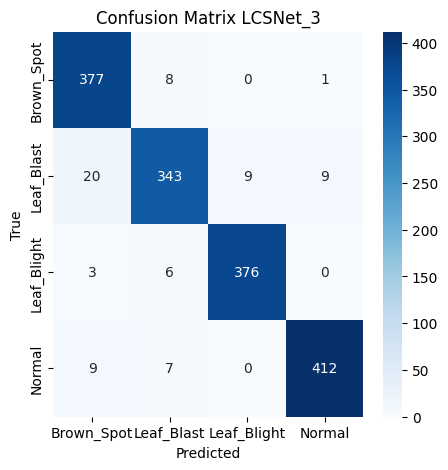

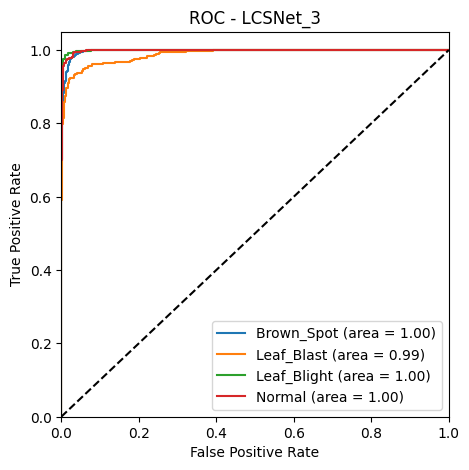

Number of test images: 1580
50/50 ━━━━━━━━━━━━━━━━━━━━ 43s 833ms/step
Total prediction time for 1580 images: 45.52 seconds
Execution time per image: 0.0288 seconds


,precision,recall,f1-score,support
Brown_Spot,92.18,97.67,94.84,386.00
Leaf_Blast,94.23,90.03,92.08,381.00
Leaf_Blight,97.66,97.66,97.66,385.00
Normal,97.63,96.26,96.94,428.00
accuracy,95.44,95.44,95.44,0.95
macro avg,95.42,95.40,95.38,1580.00
weighted avg,95.49,95.44,95.43,1580.00


In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import pandas as pd
import time
from sklearn.metrics import (
    classification_report,
    confusion_matrix,
    roc_curve,
    auc
)
from sklearn.preprocessing import label_binarize

# -----------------------------
# Model Evaluation
# -----------------------------
loss, accuracy = model.evaluate(test_generator)
print(f"Test Loss: {loss*100:.2f}")
print(f"Test Accuracy: {accuracy*100:.2f}")

# -----------------------------
# Predictions
# -----------------------------
y_pred = model.predict(test_generator)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true = test_generator.classes

# -----------------------------
# Classification Report
# -----------------------------
class_names = list(train_generator.class_indices.keys())
num_classes = len(class_names)

report = classification_report(
    y_true,
    y_pred_classes,
    target_names=class_names,
    output_dict=True
)

report_df = pd.DataFrame(report).transpose()
report_df[['precision', 'recall', 'f1-score']] *= 100  # Convert to percentages

print("\nClassification Report (in %):")
print(report_df.round(2))

# -----------------------------
# Confusion Matrix
# -----------------------------
cm = confusion_matrix(y_true, y_pred_classes)
plt.figure(figsize=(5, 5))
sns.heatmap(
    cm,
    annot=True,
    fmt='d',
    cmap='Blues',
    xticklabels=class_names,
    yticklabels=class_names
)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title(f'Confusion Matrix - {pass_name}')
plt.show()

# -----------------------------
# ROC Curves per Class
# -----------------------------
y_true_binarized = label_binarize(y_true, classes=np.arange(num_classes))

fpr, tpr, roc_auc = {}, {}, {}
for i in range(num_classes):
    fpr[i], tpr[i], _ = roc_curve(y_true_binarized[:, i], y_pred[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

plt.figure(figsize=(5, 5))
for i in range(num_classes):
    plt.plot(fpr[i], tpr[i], label=f'{class_names[i]} (area = {roc_auc[i]:.2f})')

plt.plot([0, 1], [0, 1], 'k--')  # Diagonal baseline
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title(f'ROC - {pass_name}')
plt.legend(loc="lower right")
plt.show()

# -----------------------------
# Prediction Performance Timing
# -----------------------------
if model:
    num_test_images = test_generator.samples
    print(f"Number of test images: {num_test_images}")

    # Measure total prediction time
    start_time = time.time()
    model.predict(test_generator)
    end_time = time.time()

    total_prediction_time = end_time - start_time
    print(f"Total prediction time for {num_test_images} images: {total_prediction_time:.2f} seconds")

    # Calculate average execution time per image
    if num_test_images > 0:
        execution_time_per_image = total_prediction_time / num_test_images
        print(f"Execution time per image: {execution_time_per_image:.4f} seconds")
    else:
        print("No test images found to calculate execution time per image.")
else:
    print("Model not loaded. Cannot calculate execution time.")

# Display classification report DataFrame
display(report_df.round(2))

# End Task